**SMART MODEL-PICKER**


This notebook:

Uses Whisper model to transcribe audio to text
Uses Seamless M4T v2 model to transcribe audio to text
Compares correctness for ground truth vs both models
Analyzes performance by hearing loss level
Extracts 4 audio features for neural network
Creates a neural network that predicts the better model
Supports incremental processing with file range selection
Runs neural network model based inference on validation dataset

Note: Code developed with support from Claude 4.5

1. Installation of libraries

In [21]:
!pip install -q openai-whisper
!pip install -q transformers>=4.35.0
!pip install -q librosa
!pip install -q soundfile
!pip install -q scikit-learn
!pip install -q torch torchvision torchaudio
!pip install -q accelerate
!pip install -q sentencepiece

2. Mount Google Drive (Content is stored on Google Drive)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Configuration

In [23]:
from pathlib import Path
import json
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import soundfile as sf
import whisper

from transformers import AutoProcessor, SeamlessM4Tv2Model

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

METADATA_PATH = Path("/content/drive/MyDrive/Cadenza/cadenza_data/metadata/train_metadata.json")
AUDIO_DIR_PRIMARY = Path("/content/drive/MyDrive/Cadenza/cadenza_data/train/signals")
AUDIO_DIR_FALLBACK = Path("/content/drive/MyDrive/Cadenza/cadenza_data/train/signals")

WHISPER_MODEL_NAME = "base"
LANGUAGE = "en"

SEAMLESS_MODEL_NAME = "facebook/seamless-m4t-v2-large"
SEAMLESS_TARGET_LANG = "eng"

START_FILE_INDEX = 00
END_FILE_INDEX = 1000

RESULTS_FILE = "/content/drive/MyDrive/Cadenza/transcription_results_cache_ram4.json"

RANDOM_SEED = 42
TEST_SIZE = 0.2
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.001


np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32


4. Load Metadata

In [24]:
def load_metadata_safe(path: Path):
    if not path.exists():
        raise FileNotFoundError(
            f"Metadata file not found: {path.resolve()}\n"
            "Please make sure the dataset is available with the correct path."
        )
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

        for row in data:
          row.setdefault("prompt", row.get("original_prompt", "") or "")
          row.setdefault("n_words", None)
          row.setdefault("correctness", None)
          row.setdefault("hearing_loss", "Unknown")
    return data


metadata = load_metadata_safe(METADATA_PATH)
df_meta = pd.DataFrame(metadata)


keep_cols = ["signal", "fma", "prompt", "n_words", "correctness", "hearing_loss"]
df_meta = df_meta[[c for c in keep_cols if c in df_meta.columns]]

print(f"Loaded {len(df_meta)} total rows from metadata")
print(f"Will process rows {START_FILE_INDEX} to {END_FILE_INDEX-1}")
print(f"\nHearing loss distribution in full dataset:")
print(df_meta['hearing_loss'].value_counts())
print(f"\nFirst few rows:")
display(df_meta.head(10))

Loaded 8802 total rows from metadata
Will process rows 0 to 999

Hearing loss distribution in full dataset:
hearing_loss
Mild        2935
Moderate    2934
No Loss     2933
Name: count, dtype: int64

First few rows:


,signal,fma,prompt,n_words,correctness,hearing_loss
0,c221f2084c780e8f212f4697,147301,cos you better hold on,5,0.000000,Moderate
1,63de05fbfcab2d7748b83cb3,000649,and then lower it down again,6,0.166667,Mild
2,cf74c013a02d82d04254a910,022968,the blind sleep and the deaf and dumb sleep,9,0.777778,No Loss
3,56f3fb4847d2c90f38e8e983,124993,a street a couple of cars and maybe some trees,10,0.000000,Moderate
4,b2486a8e181f84acd2db4d61,001750,in my mind i can see is fine,8,0.000000,Moderate
5,4119c3d170a7c478c00ef21d,081474,we slaves and we masters flesh out beast disas...,9,0.222222,Moderate
6,60aa30c1cde48138efe6d172,022481,you are sleeping with a pig,6,0.833333,Mild
7,710c8b1d9cc589b5414634bb,153769,but maybe getting far from the dark,7,1.000000,No Loss
8,09449f9926c4222b7b6d0460,131956,cheyenne cheyenne hop on the ponies,6,0.000000,No Loss
9,6cc97125bb708b1fa5a55e7e,022479,he was mauvish in the shops,6,0.166667,Mild


5. Text Scoring

In [25]:
_word_re = re.compile(r"[a-zA-Z0-9']+")

def normalize_text(text: str) -> str:
    text = text.lower()
    tokens = _word_re.findall(text)
    return " ".join(tokens)

def tokenize(text: str):
    return normalize_text(text).split()

def bag_overlap_count(ref_tokens, hyp_tokens) -> int:
    ref_counter = Counter(ref_tokens)
    hyp_counter = Counter(hyp_tokens)
    return sum(min(c, hyp_counter.get(w, 0)) for w, c in ref_counter.items())

def compute_words_correct_and_rate(prompt_text: str, transcript_text: str):
    ref_tokens = tokenize(prompt_text)
    hyp_tokens = tokenize(transcript_text)
    n_words = len(ref_tokens)
    wc = bag_overlap_count(ref_tokens, hyp_tokens)
    rate = (wc / n_words) if n_words > 0 else 0.0
    return wc, rate


6. Audio Feature Extraction

In [26]:
def extract_bpm(audio_path, sr=22050):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        if isinstance(tempo, np.ndarray):
            tempo = float(tempo[0]) if len(tempo) > 0 else 120.0
        return float(tempo)
    except Exception as e:
        print(f"Error extracting BPM from {audio_path}: {e}")
        return 120.0

def extract_zero_crossing_rate(audio_path, sr=22050):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        return float(np.mean(zcr))
    except Exception as e:
        print(f"Error extracting ZCR from {audio_path}: {e}")
        return 0.05

def extract_spectral_centroid(audio_path, sr=22050):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        return float(np.mean(spectral_centroid))
    except Exception as e:
        print(f"Error extracting spectral centroid from {audio_path}: {e}")
        return 2000.0

def extract_spectral_rolloff(audio_path, sr=22050):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
        return float(np.mean(spectral_rolloff))
    except Exception as e:
        print(f"Error extracting spectral rolloff from {audio_path}: {e}")
        return 3000.0

def extract_audio_features(audio_path, sr=22050):
    bpm = extract_bpm(audio_path, sr)
    zcr = extract_zero_crossing_rate(audio_path, sr)
    return bpm, zcr

print("Audio feature extraction functions defined.")
print("Features: BPM, ZCR, Spectral Centroid, Spectral Rolloff")

Audio feature extraction functions defined.
Features: BPM, ZCR, Spectral Centroid, Spectral Rolloff


7. Load Whisper Model

In [27]:
print(f"Loading Whisper model '{WHISPER_MODEL_NAME}' on {device}...")
whisper_model = whisper.load_model(WHISPER_MODEL_NAME, device=device)
print(f"Whisper model '{WHISPER_MODEL_NAME}' loaded successfully!")

Loading Whisper model 'base' on cuda...
Whisper model 'base' loaded successfully!


8. Load Seamless Model

In [28]:
print(f"\nLoading Seamless M4T v2 model '{SEAMLESS_MODEL_NAME}'...")

seamless_processor = AutoProcessor.from_pretrained(SEAMLESS_MODEL_NAME)
seamless_model = SeamlessM4Tv2Model.from_pretrained(
    SEAMLESS_MODEL_NAME,
    torch_dtype=torch_dtype
).to(device)

print(f"Seamless M4T v2 model loaded successfully on {device}!")
print(f"Model size: ~{sum(p.numel() for p in seamless_model.parameters()) / 1e9:.1f}B parameters")


Loading Seamless M4T v2 model 'facebook/seamless-m4t-v2-large'...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Seamless M4T v2 model loaded successfully on cuda!
Model size: ~2.3B parameters


9. Transcription Function

In [29]:
def transcribe_with_whisper(audio_path, model, language="en"):
    try:
        result = model.transcribe(str(audio_path), language=language)
        return result["text"].strip()
    except Exception as e:
        print(f"Whisper error on {audio_path}: {e}")
        return ""

def transcribe_with_seamless(audio_path, model, processor, target_lang="eng", device="cuda"):
    try:
        audio, sample_rate = librosa.load(str(audio_path), sr=16000, mono=True)
        audio_inputs = processor(audios=audio, sampling_rate=16000, return_tensors="pt")
        audio_inputs = {k: v.to(device) for k, v in audio_inputs.items()}

        output_tokens = model.generate(
            **audio_inputs,
            tgt_lang=target_lang,
            generate_speech=False
        )

        transcription = processor.decode(output_tokens[0].tolist()[0], skip_special_tokens=True)
        return transcription.strip()

    except Exception as e:
        print(f"Seamless M4T error on {audio_path}: {e}")
        return ""



10. Process Audio Files

In [30]:
from tqdm.auto import tqdm

def find_audio_file(signal_id, audio_dir_primary, audio_dir_fallback):
    """Find audio file for given signal ID."""
    for ext in [".wav", ".mp3", ".flac"]:
        path = audio_dir_primary / f"{signal_id}{ext}"
        if path.exists():
            return path
        path = audio_dir_fallback / f"{signal_id}{ext}"
        if path.exists():
            return path
    return None

results_cache = {}
if Path(RESULTS_FILE).exists():
    try:
        with open(RESULTS_FILE, 'r') as f:
            results_cache = json.load(f)
        print(f"\nLoaded {len(results_cache)} existing results from {RESULTS_FILE}")
    except Exception as e:
        print(f"Could not load existing cache: {e}")
        results_cache = {}
else:
    print(f"\nNo existing cache found. Creating new {RESULTS_FILE}")

df_meta_range = df_meta.iloc[START_FILE_INDEX:END_FILE_INDEX].copy()

print(f"\n{'='*70}")
print(f"Processing files {START_FILE_INDEX} to {END_FILE_INDEX-1} ({len(df_meta_range)} files)")
print(f"{'='*70}\n")

processed_count = 0
skipped_count = 0

for idx, row in tqdm(df_meta_range.iterrows(), total=len(df_meta_range), desc="Processing"):
    signal_id = row["signal"]
    ground_truth = row.get("prompt", "")
    hearing_loss = row.get("hearing_loss", "Unknown")

    if signal_id in results_cache:
        skipped_count += 1
        continue

    audio_path = find_audio_file(signal_id, AUDIO_DIR_PRIMARY, AUDIO_DIR_FALLBACK)
    if audio_path is None:
        print(f"Audio file not found: {signal_id}")
        continue
    bpm, zcr = extract_audio_features(audio_path)
    spectral_centroid = extract_spectral_centroid(audio_path)
    spectral_rolloff = extract_spectral_rolloff(audio_path)
    whisper_transcript = transcribe_with_whisper(audio_path, whisper_model, LANGUAGE)
    seamless_transcript = transcribe_with_seamless(
        audio_path, seamless_model, seamless_processor, SEAMLESS_TARGET_LANG, device
    )


    whisper_wc, whisper_rate = compute_words_correct_and_rate(ground_truth, whisper_transcript)
    seamless_wc, seamless_rate = compute_words_correct_and_rate(ground_truth, seamless_transcript)


    results_cache[signal_id] = {
        "signal_id": signal_id,
        "ground_truth": ground_truth,
        "hearing_loss": hearing_loss,
        "whisper_transcript": whisper_transcript,
        "seamless_transcript": seamless_transcript,
        "whisper_words_correct": int(whisper_wc),
        "whisper_correctness": float(whisper_rate),
        "seamless_words_correct": int(seamless_wc),
        "seamless_correctness": float(seamless_rate),
        "bpm": float(bpm),
        "zcr": float(zcr),
        "spectral_centroid": float(spectral_centroid),
        "spectral_rolloff": float(spectral_rolloff),
        "better_model": "whisper" if whisper_rate >= seamless_rate else "seamless",
        "file_index": int(idx)
    }
    processed_count += 1


try:
    with open(RESULTS_FILE, 'w') as f:
        json.dump(results_cache, f, indent=2)
    print(f"\n{'='*70}")
    print(f"Results saved to {RESULTS_FILE}")
    print(f"Total cached: {len(results_cache)} | New: {processed_count} | Skipped: {skipped_count}")
    print(f"{'='*70}\n")
except Exception as e:
    print(f"Error saving cache: {e}")


df_results = pd.DataFrame([results_cache[k] for k in results_cache.keys()])
print(f"Dataframe created with {len(df_results)} total results\n")
display(df_results.head(10))


No existing cache found. Creating new /content/drive/MyDrive/Cadenza/transcription_results_cache_ram4.json

Processing files 0 to 999 (1000 files)



Processing:   0%|          | 0/1000 [00:00<?, ?it/s]


Results saved to /content/drive/MyDrive/Cadenza/transcription_results_cache_ram4.json
Total cached: 1000 | New: 1000 | Skipped: 0

Dataframe created with 1000 total results



,signal_id,ground_truth,hearing_loss,whisper_transcript,seamless_transcript,whisper_words_correct,whisper_correctness,seamless_words_correct,seamless_correctness,bpm,zcr,spectral_centroid,spectral_rolloff,better_model,file_index
0,c221f2084c780e8f212f4697,cos you better hold on,Moderate,Could you better hold on?,I'm going to kill you.,4,0.800000,1,0.200000,161.499023,0.128567,1724.851293,2508.961049,whisper,0
1,63de05fbfcab2d7748b83cb3,and then lower it down again,Mild,And then roll it down again.,And then lower it down again.,5,0.833333,6,1.000000,43.796345,0.071642,875.475337,1317.612712,seamless,1
2,cf74c013a02d82d04254a910,the blind sleep and the deaf and dumb sleep,No Loss,"So fly, sleeper than death and up sleep",I'm supplying sleep and the deaf don't sleep,2,0.222222,5,0.555556,61.523438,0.076414,1761.348398,3344.062944,seamless,2
3,56f3fb4847d2c90f38e8e983,a street a couple of cars and maybe some trees,Moderate,I saw your card card and forgot all the questi...,I'm going to kill you and maybe I'll be killed.,1,0.100000,2,0.200000,80.749512,0.120722,3140.969991,6992.309570,seamless,3
4,b2486a8e181f84acd2db4d61,in my mind i can see is fine,Moderate,"I love you, baby. I love you.",[The music is so good that it's a hit],1,0.125000,1,0.125000,107.666016,0.048581,770.873511,1595.557832,whisper,4
5,4119c3d170a7c478c00ef21d,we slaves and we masters flesh out beast disas...,Moderate,"We fight them, we master, but shall be disastr...","And also, and we're human, we're traveling.",2,0.222222,1,0.111111,123.046875,0.047330,812.138554,1421.807815,whisper,5
6,60aa30c1cde48138efe6d172,you are sleeping with a pig,Mild,You're sleeping with a pig.,You're sleeping with a pig.,4,0.666667,4,0.666667,83.354335,0.068575,1026.179215,1749.381469,whisper,6
7,710c8b1d9cc589b5414634bb,but maybe getting far from the dark,No Loss,But maybe get far from the dark,But may begin far from the darkness,6,0.857143,4,0.571429,161.499023,0.056726,1695.059257,3501.951697,whisper,7
8,09449f9926c4222b7b6d0460,cheyenne cheyenne hop on the ponies,No Loss,"It is flying, flying, flying, you are flyin to...",I'm going to take a look at it.,0,0.000000,0,0.000000,66.256010,0.086456,1210.722503,1788.312704,whisper,8
9,6cc97125bb708b1fa5a55e7e,he was mauvish in the shops,Mild,He would know which in the child,He was a little boy in that trunk.,3,0.500000,3,0.500000,103.359375,0.049490,698.441967,1117.121740,whisper,9


11. Performance Analysis

In [31]:
print("\n" + "="*70)
print("COMPARATIVE ANALYSIS: WHISPER VS SEAMLESS M4T V2")
print("="*70 + "\n")

# Overall statistics
print("Overall Performance:")
print("-" * 40)
print(f"Whisper:    {df_results['whisper_correctness'].mean():.4f} ± {df_results['whisper_correctness'].std():.4f}")
print(f"Seamless:   {df_results['seamless_correctness'].mean():.4f} ± {df_results['seamless_correctness'].std():.4f}")

# Performance by hearing loss level
print(f"\n{'='*70}")
print("PERFORMANCE BY HEARING LOSS LEVEL")
print("="*70 + "\n")

for hearing_loss_level in sorted(df_results['hearing_loss'].unique()):
    subset = df_results[df_results['hearing_loss'] == hearing_loss_level]
    if len(subset) == 0:
        continue

    print(f"\n📊 {hearing_loss_level} (n={len(subset)}):")
    print("-" * 40)
    whisper_avg = subset['whisper_correctness'].mean()
    seamless_avg = subset['seamless_correctness'].mean()

    print(f"  Whisper:  {whisper_avg:.4f}")
    print(f"  Seamless: {seamless_avg:.4f}")

    if whisper_avg > seamless_avg:
        diff = ((whisper_avg - seamless_avg) / seamless_avg) * 100
        print(f"  Winner: Whisper (+{diff:.1f}%)")
    elif seamless_avg > whisper_avg:
        diff = ((seamless_avg - whisper_avg) / whisper_avg) * 100
        print(f"  Winner: Seamless (+{diff:.1f}%)")
    else:
        print(f"  Tie")

# Model preference
print(f"\n\nOverall Model Preference:")
print("-" * 40)
better_counts = df_results['better_model'].value_counts()
for model, count in better_counts.items():
    pct = (count / len(df_results)) * 100
    print(f"  {model.capitalize()}: {count} files ({pct:.1f}%)")

# Audio features statistics
print(f"\n\nAudio Features Summary:")
print("-" * 40)
print(f"BPM:                {df_results['bpm'].mean():.2f} ± {df_results['bpm'].std():.2f}")
print(f"ZCR:                {df_results['zcr'].mean():.4f} ± {df_results['zcr'].std():.4f}")
print(f"Spectral Centroid:  {df_results['spectral_centroid'].mean():.2f} ± {df_results['spectral_centroid'].std():.2f} Hz")
print(f"Spectral Rolloff:   {df_results['spectral_rolloff'].mean():.2f} ± {df_results['spectral_rolloff'].std():.2f} Hz")

# Save summary CSV
df_results.to_csv("transcription_results_summary.csv", index=False)
print(f"\n✅ Summary saved to: transcription_results_summary.csv")


COMPARATIVE ANALYSIS: WHISPER VS SEAMLESS M4T V2

Overall Performance:
----------------------------------------
Whisper:    0.2820 ± 0.3065
Seamless:   0.3581 ± 0.3182

PERFORMANCE BY HEARING LOSS LEVEL


📊 Mild (n=324):
----------------------------------------
  Whisper:  0.2483
  Seamless: 0.3607
  Winner: Seamless (+45.2%)

📊 Moderate (n=343):
----------------------------------------
  Whisper:  0.1929
  Seamless: 0.2969
  Winner: Seamless (+53.9%)

📊 No Loss (n=333):
----------------------------------------
  Whisper:  0.4066
  Seamless: 0.4188
  Winner: Seamless (+3.0%)


Overall Model Preference:
----------------------------------------
  Whisper: 550 files (55.0%)
  Seamless: 450 files (45.0%)


Audio Features Summary:
----------------------------------------
BPM:                118.09 ± 39.01
ZCR:                0.0702 ± 0.0457
Spectral Centroid:  1311.90 ± 863.72 Hz
Spectral Rolloff:   2508.35 ± 1807.79 Hz

✅ Summary saved to: transcription_results_summary.csv


12. Visualizations

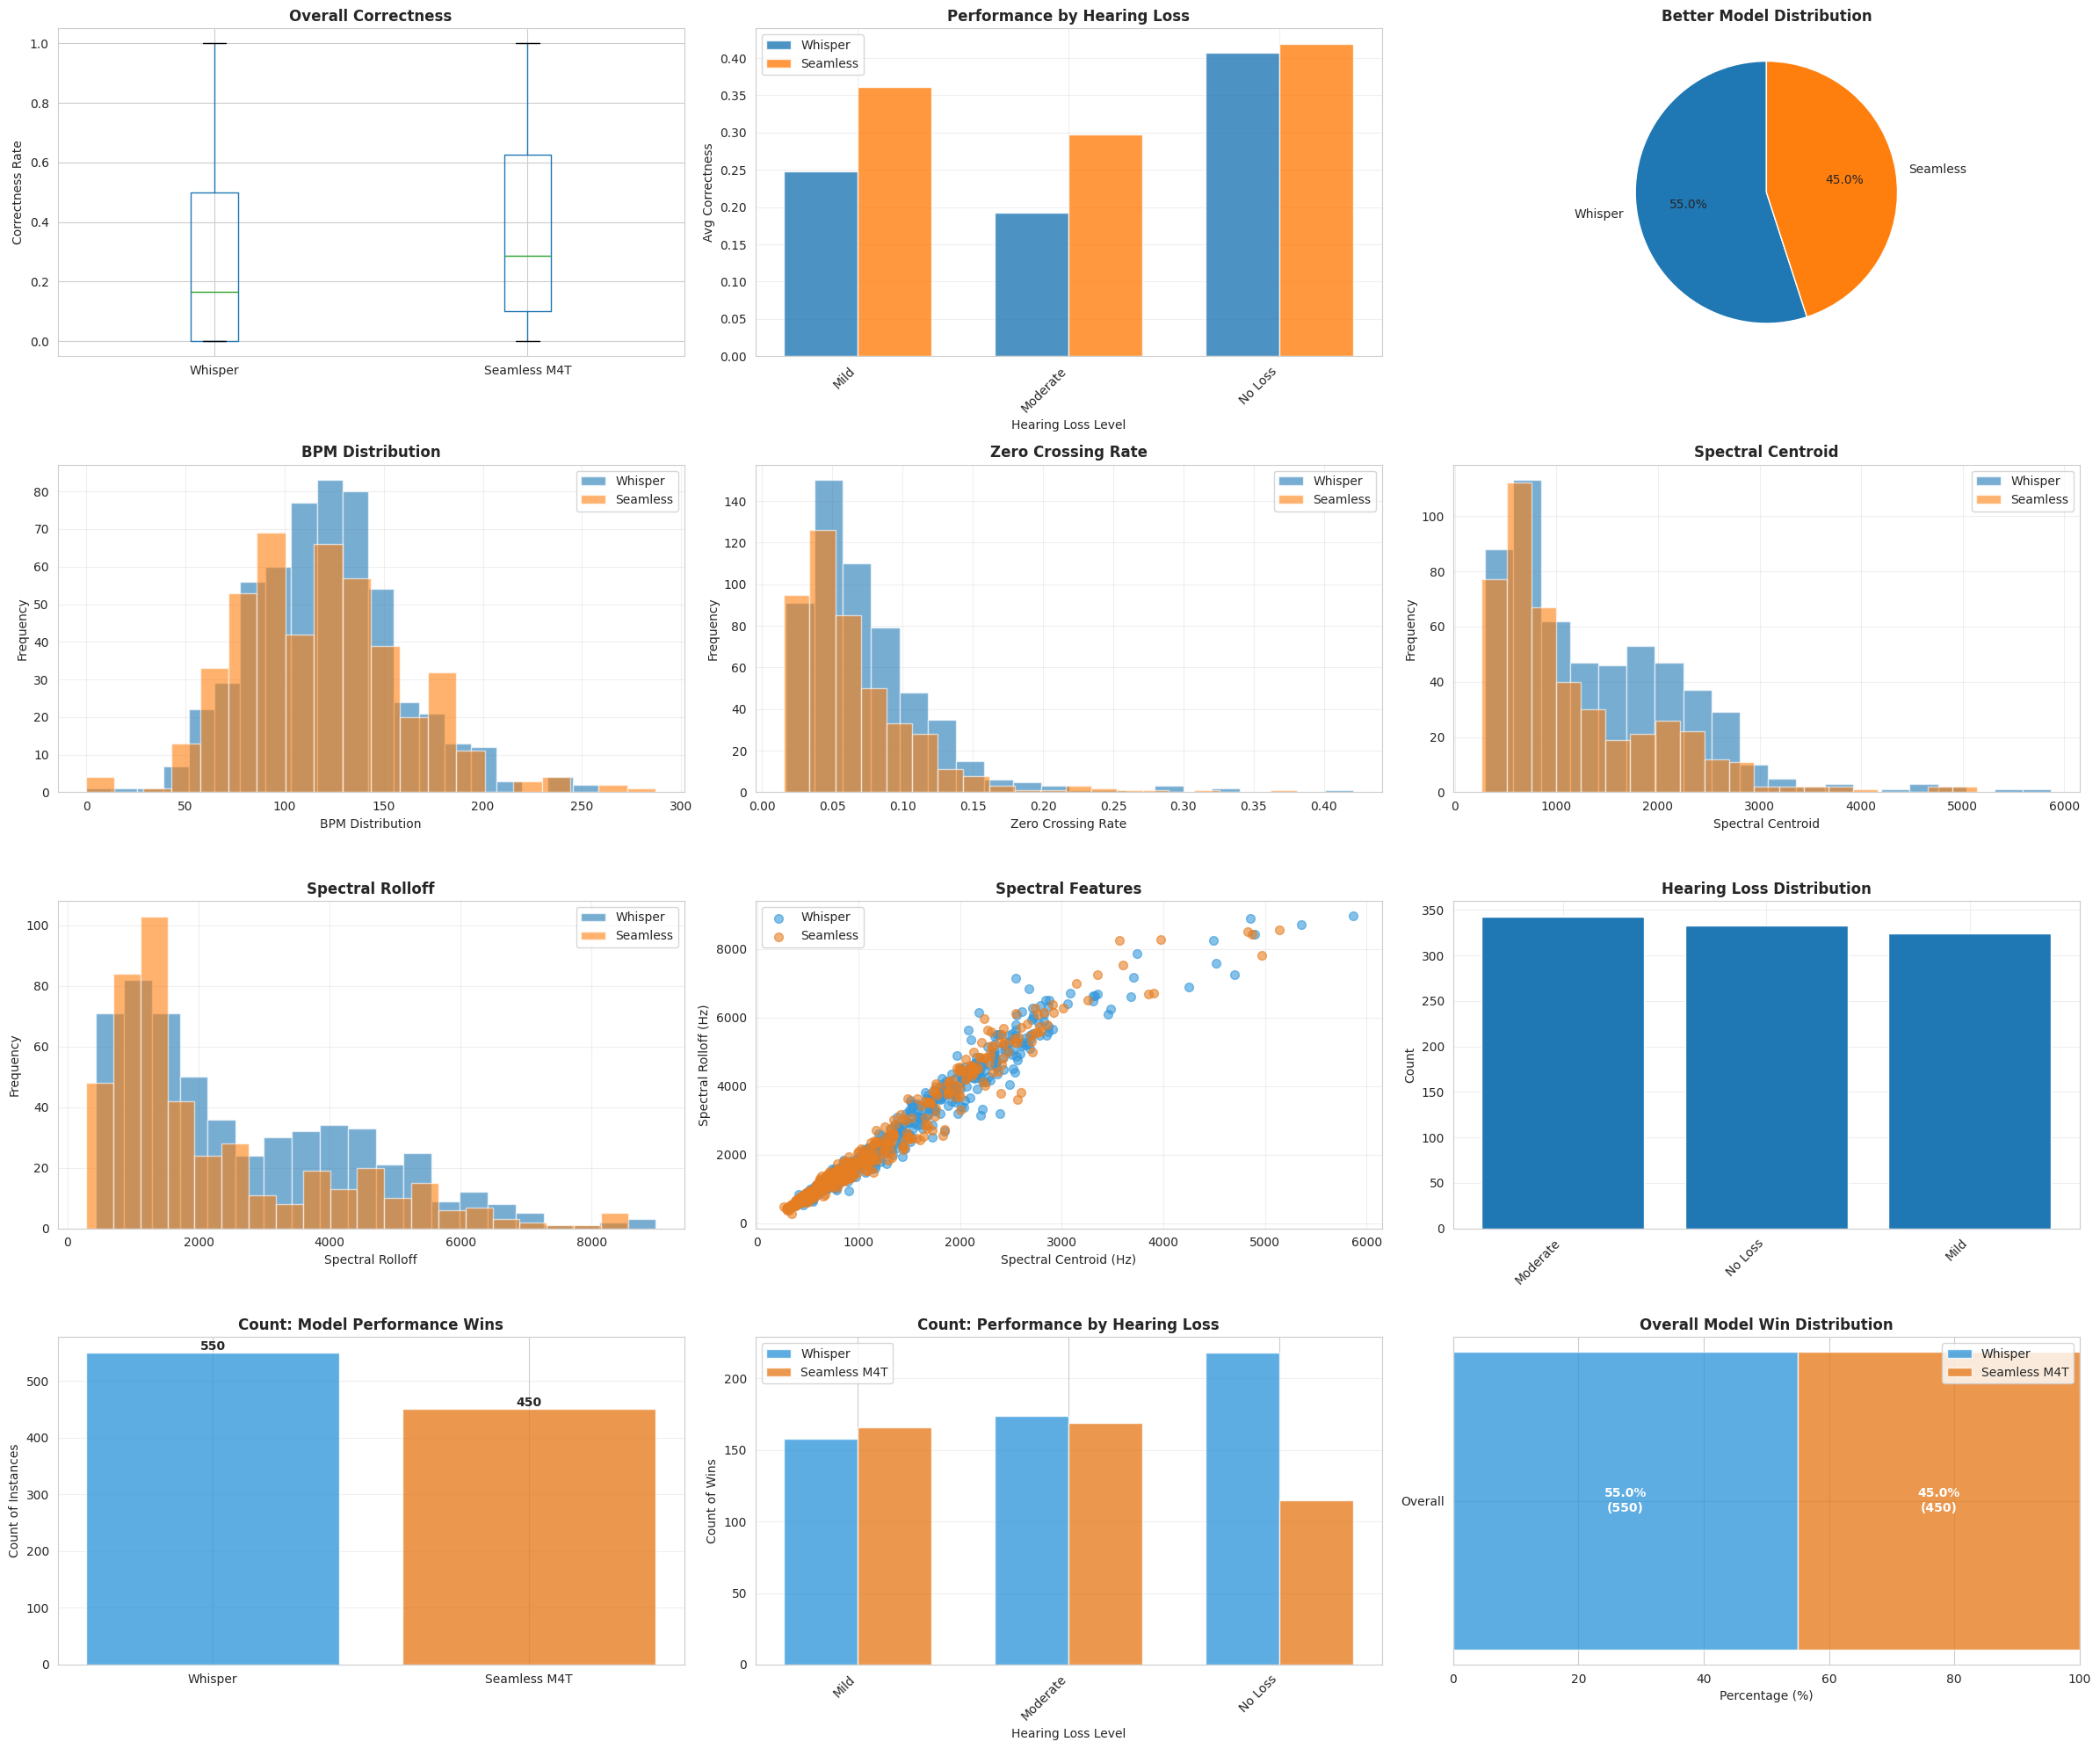

✅ Visualizations saved as 'transcription_analysis_complete.png'

📊 Summary Statistics:
  Total instances analyzed: 1000
  Whisper wins: 550 (55.0%)
  Seamless M4T wins: 450 (45.0%)

  Breakdown by Hearing Loss Level:
    Mild: Whisper=158 (48.8%), Seamless=166 (51.2%)
    Moderate: Whisper=174 (50.7%), Seamless=169 (49.3%)
    No Loss: Whisper=218 (65.5%), Seamless=115 (34.5%)


In [32]:
sns.set_style("whitegrid")

# Load results from JSON file for count analysis
with open(RESULTS_FILE, 'r') as f:
    results_cache = json.load(f)
df_results_from_json = pd.DataFrame([results_cache[k] for k in results_cache.keys()])

fig = plt.figure(figsize=(24, 20))

# 1. Overall correctness comparison
ax1 = plt.subplot(4, 3, 1)
df_results[['whisper_correctness', 'seamless_correctness']].boxplot(ax=ax1)
ax1.set_title('Overall Correctness', fontweight='bold')
ax1.set_ylabel('Correctness Rate')
ax1.set_xticklabels(['Whisper', 'Seamless M4T'])

# 2. Performance by hearing loss level
ax2 = plt.subplot(4, 3, 2)
hearing_loss_levels = sorted(df_results['hearing_loss'].unique())
x_pos = np.arange(len(hearing_loss_levels))
whisper_means = [df_results[df_results['hearing_loss']==hl]['whisper_correctness'].mean()
                 for hl in hearing_loss_levels]
seamless_means = [df_results[df_results['hearing_loss']==hl]['seamless_correctness'].mean()
                  for hl in hearing_loss_levels]
width = 0.35
ax2.bar(x_pos - width/2, whisper_means, width, label='Whisper', alpha=0.8)
ax2.bar(x_pos + width/2, seamless_means, width, label='Seamless', alpha=0.8)
ax2.set_xlabel('Hearing Loss Level')
ax2.set_ylabel('Avg Correctness')
ax2.set_title('Performance by Hearing Loss', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(hearing_loss_levels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Model preference pie
ax3 = plt.subplot(4, 3, 3)
better_counts = df_results['better_model'].value_counts()
ax3.pie(better_counts.values, labels=[l.capitalize() for l in better_counts.index],
        autopct='%1.1f%%', startangle=90)
ax3.set_title('Better Model Distribution', fontweight='bold')

# 4-7. Audio features histograms
features = ['bpm', 'zcr', 'spectral_centroid', 'spectral_rolloff']
titles = ['BPM Distribution', 'Zero Crossing Rate', 'Spectral Centroid', 'Spectral Rolloff']
for i, (feat, title) in enumerate(zip(features, titles)):
    ax = plt.subplot(4, 3, i+4)
    for model in ['whisper', 'seamless']:
        data = df_results[df_results['better_model'] == model][feat]
        ax.hist(data, bins=20, alpha=0.6, label=model.capitalize())
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')
    ax.set_title(title, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 8. Scatter: Spectral Centroid vs Rolloff
ax8 = plt.subplot(4, 3, 8)
for model, color in zip(['whisper', 'seamless'], ['#3498db', '#e67e22']):
    data = df_results[df_results['better_model'] == model]
    ax8.scatter(data['spectral_centroid'], data['spectral_rolloff'],
               alpha=0.6, c=color, label=model.capitalize(), s=50)
ax8.set_xlabel('Spectral Centroid (Hz)')
ax8.set_ylabel('Spectral Rolloff (Hz)')
ax8.set_title('Spectral Features', fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Hearing loss distribution
ax9 = plt.subplot(4, 3, 9)
hearing_loss_counts = df_results['hearing_loss'].value_counts()
ax9.bar(range(len(hearing_loss_counts)), hearing_loss_counts.values)
ax9.set_xticks(range(len(hearing_loss_counts)))
ax9.set_xticklabels(hearing_loss_counts.index, rotation=45, ha='right')
ax9.set_ylabel('Count')
ax9.set_title('Hearing Loss Distribution', fontweight='bold')
ax9.grid(True, alpha=0.3)

# NEW: 10. Overall count of instances where each model performs better
ax10 = plt.subplot(4, 3, 10)
whisper_better_count = (df_results_from_json['better_model'] == 'whisper').sum()
seamless_better_count = (df_results_from_json['better_model'] == 'seamless').sum()
models = ['Whisper', 'Seamless M4T']
counts = [whisper_better_count, seamless_better_count]
colors = ['#3498db', '#e67e22']
bars = ax10.bar(models, counts, color=colors, alpha=0.8)
ax10.set_ylabel('Count of Instances')
ax10.set_title('Count: Model Performance Wins', fontweight='bold')
ax10.grid(True, alpha=0.3, axis='y')
# Add count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count)}',
             ha='center', va='bottom', fontweight='bold')

# NEW: 11. Count of instances by hearing loss level
ax11 = plt.subplot(4, 3, 11)
hearing_loss_levels = sorted(df_results_from_json['hearing_loss'].unique())
whisper_counts_by_hl = []
seamless_counts_by_hl = []
for hl in hearing_loss_levels:
    hl_data = df_results_from_json[df_results_from_json['hearing_loss'] == hl]
    whisper_counts_by_hl.append((hl_data['better_model'] == 'whisper').sum())
    seamless_counts_by_hl.append((hl_data['better_model'] == 'seamless').sum())

x_pos = np.arange(len(hearing_loss_levels))
width = 0.35
ax11.bar(x_pos - width/2, whisper_counts_by_hl, width, label='Whisper',
         color='#3498db', alpha=0.8)
ax11.bar(x_pos + width/2, seamless_counts_by_hl, width, label='Seamless M4T',
         color='#e67e22', alpha=0.8)
ax11.set_xlabel('Hearing Loss Level')
ax11.set_ylabel('Count of Wins')
ax11.set_title('Count: Performance by Hearing Loss', fontweight='bold')
ax11.set_xticks(x_pos)
ax11.set_xticklabels(hearing_loss_levels, rotation=45, ha='right')
ax11.legend()
ax11.grid(True, alpha=0.3, axis='y')

# NEW: 12. Stacked bar chart for overall breakdown
ax12 = plt.subplot(4, 3, 12)
total_instances = len(df_results_from_json)
whisper_pct = (whisper_better_count / total_instances) * 100
seamless_pct = (seamless_better_count / total_instances) * 100

bars = ax12.barh(['Overall'], [whisper_pct], color='#3498db', alpha=0.8, label='Whisper')
ax12.barh(['Overall'], [seamless_pct], left=[whisper_pct], color='#e67e22',
          alpha=0.8, label='Seamless M4T')
ax12.set_xlabel('Percentage (%)')
ax12.set_title('Overall Model Win Distribution', fontweight='bold')
ax12.legend(loc='upper right')
ax12.set_xlim([0, 100])
# Add percentage labels
ax12.text(whisper_pct/2, 0, f'{whisper_pct:.1f}%\n({whisper_better_count})',
         ha='center', va='center', fontweight='bold', color='white')
ax12.text(whisper_pct + seamless_pct/2, 0, f'{seamless_pct:.1f}%\n({seamless_better_count})',
         ha='center', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('transcription_analysis_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved as 'transcription_analysis_complete.png'")
print(f"\n📊 Summary Statistics:")
print(f"  Total instances analyzed: {total_instances}")
print(f"  Whisper wins: {whisper_better_count} ({whisper_pct:.1f}%)")
print(f"  Seamless M4T wins: {seamless_better_count} ({seamless_pct:.1f}%)")
print(f"\n  Breakdown by Hearing Loss Level:")
for hl, w_count, s_count in zip(hearing_loss_levels, whisper_counts_by_hl, seamless_counts_by_hl):
    total_hl = w_count + s_count
    print(f"    {hl}: Whisper={w_count} ({w_count/total_hl*100:.1f}%), Seamless={s_count} ({s_count/total_hl*100:.1f}%)")


13. Data Preparation for Neural Network

In [33]:
with open(RESULTS_FILE, 'r') as f:
    results_cache = json.load(f)

df_results_for_training = pd.DataFrame([results_cache[k] for k in results_cache.keys()])

print(f"Loaded {len(df_results_for_training)} samples from {RESULTS_FILE}")
print(f"\nDataframe columns: {df_results_for_training.columns.tolist()}")


feature_cols = ['bpm', 'zcr', 'spectral_centroid', 'spectral_rolloff']
X = df_results_for_training[feature_cols].values
y = (df_results_for_training['better_model'] == 'whisper').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print("\nEnhanced neural network data prepared:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Input features: {X_train.shape[1]} (BPM, ZCR, Spectral Centroid, Spectral Rolloff)")
print(f"  Class distribution in training:")
print(f"    Whisper: {np.sum(y_train)} ({np.sum(y_train)/len(y_train)*100:.1f}%)")
print(f"    Seamless: {len(y_train) - np.sum(y_train)} ({(len(y_train) - np.sum(y_train))/len(y_train)*100:.1f}%)")


Loaded 1000 samples from /content/drive/MyDrive/Cadenza/transcription_results_cache_ram4.json

Dataframe columns: ['signal_id', 'ground_truth', 'hearing_loss', 'whisper_transcript', 'seamless_transcript', 'whisper_words_correct', 'whisper_correctness', 'seamless_words_correct', 'seamless_correctness', 'bpm', 'zcr', 'spectral_centroid', 'spectral_rolloff', 'better_model', 'file_index']

Enhanced neural network data prepared:
  Training samples: 800
  Test samples: 200
  Input features: 4 (BPM, ZCR, Spectral Centroid, Spectral Rolloff)
  Class distribution in training:
    Whisper: 440 (55.0%)
    Seamless: 360 (45.0%)


14. Neural Network Model

In [34]:
class EnhancedModelSelector(nn.Module):
    def __init__(self, input_size=4, hidden_sizes=[32, 16, 8], dropout_rate=0.3):
        super(EnhancedModelSelector, self).__init__()

        # Input layer
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.dropout1 = nn.Dropout(dropout_rate)

        # Hidden layer 1
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.dropout2 = nn.Dropout(dropout_rate)

        # Hidden layer 2
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.dropout3 = nn.Dropout(dropout_rate)

        # Output layer
        self.fc4 = nn.Linear(hidden_sizes[2], 2)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

# Initialize model
model = EnhancedModelSelector().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("\nEnhanced Neural Network Architecture:")
print("=" * 50)
print(model)
print("=" * 50)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Input features: 4 (BPM, ZCR, Spectral Centroid, Spectral Rolloff)")
print(f"Architecture: 4 → 32 → 16 → 8 → 2")


Enhanced Neural Network Architecture:
EnhancedModelSelector(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=8, out_features=2, bias=True)
  (relu): ReLU()
)

Total parameters: 954
Input features: 4 (BPM, ZCR, Spectral Centroid, Spectral Rolloff)
Architecture: 4 → 32 → 16 → 8 → 2


15. Neural Network Training


Starting training...

Epochs: 50 | Batch size: 16 | Learning rate: 0.001
Epoch [10/50] | Loss: 0.6840 | Accuracy: 58.12%
Epoch [20/50] | Loss: 0.6797 | Accuracy: 56.50%
Epoch [30/50] | Loss: 0.6805 | Accuracy: 55.50%
Epoch [40/50] | Loss: 0.6789 | Accuracy: 55.88%
Epoch [50/50] | Loss: 0.6773 | Accuracy: 56.62%
Training complete!


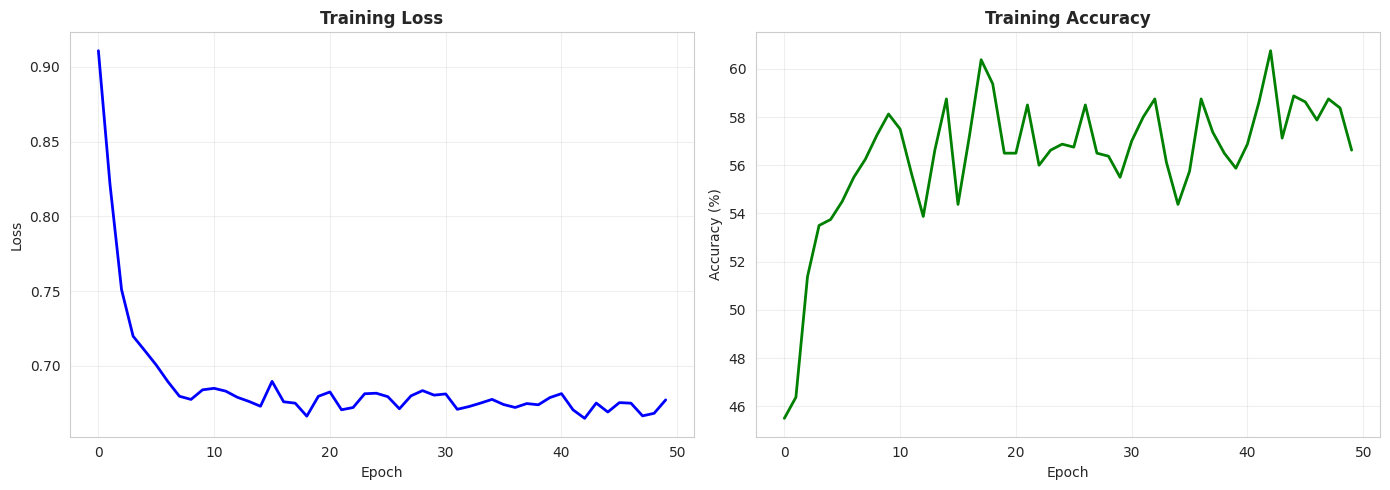


Final Training Loss: 0.6773
Final Training Accuracy: 56.62%


In [35]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

model = EnhancedModelSelector(input_size=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nStarting training...")
print(f"\nEpochs: {EPOCHS} | Batch size: {BATCH_SIZE} | Learning rate: {LEARNING_RATE}")
print("="*70)

train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

print("="*70)
print("Training complete!")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, 'b-', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(train_accuracies, 'g-', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")

16. Model Evaluation

In [36]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred = torch.max(outputs, 1)
    y_pred = y_pred.cpu().numpy()

accuracy = accuracy_score(y_test, y_pred)

print("\n" + "=" * 60)
print("ENHANCED MODEL EVALUATION")
print("=" * 60)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred, target_names=['Seamless M4T', 'Whisper']))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print("-" * 60)
print("                Predicted Seamless  Predicted Whisper")
print(f"Actual Seamless      {cm[0,0]:5d}              {cm[0,1]:5d}")
print(f"Actual Whisper       {cm[1,0]:5d}              {cm[1,1]:5d}")


ENHANCED MODEL EVALUATION

Test Accuracy: 54.50%

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

Seamless M4T       0.49      0.32      0.39        90
     Whisper       0.57      0.73      0.64       110

    accuracy                           0.55       200
   macro avg       0.53      0.52      0.51       200
weighted avg       0.53      0.55      0.53       200


Confusion Matrix:
------------------------------------------------------------
                Predicted Seamless  Predicted Whisper
Actual Seamless         29                 61
Actual Whisper          30                 80


17. NN Model on Validation Dataset

In [37]:
VALIDATION_START_INDEX = 0
VALIDATION_END_INDEX = 1175
VALIDATION_RESULTS_FILE = "/content/drive/MyDrive/Cadenza/validation_resultsram4.json"


VALIDATION_METADATA_PATH = Path("/content/drive/MyDrive/Cadenza/cadenza_data/metadata/valid_metadata.json")
VALIDATION_AUDIO_DIR_PRIMARY = Path("/content/drive/MyDrive/Cadenza/cadenza_data/valid/signals")
VALIDATION_AUDIO_DIR_FALLBACK = Path("/content/drive/MyDrive/Cadenza/cadenza_data/valid/signals")

print(f"\n{'='*70}")
print("VALIDATION MODE: Neural Network Model Selection")
print(f"{'='*70}")
print(f"Validation file range: [{VALIDATION_START_INDEX}:{VALIDATION_END_INDEX}]")
print(f"Output file: {VALIDATION_RESULTS_FILE}")
print(f"{'='*70}\n")


def load_validation_metadata(path: Path):
    """Load validation metadata file."""
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        if isinstance(data, dict):
            return pd.DataFrame([data])
        elif isinstance(data, list):
            return pd.DataFrame(data)
        else:
            raise ValueError(f"Unexpected metadata format: {type(data)}")
    except Exception as e:
        print(f"Error loading metadata from {path}: {e}")
        return None

df_validation_meta = load_validation_metadata(VALIDATION_METADATA_PATH)

if df_validation_meta is None or len(df_validation_meta) == 0:
    print("No validation metadata loaded. Please check the path.")
else:
    print(f"Loaded {len(df_validation_meta)} validation samples")

    df_validation_range = df_validation_meta.iloc[VALIDATION_START_INDEX:VALIDATION_END_INDEX].copy()
    print(f"Processing {len(df_validation_range)} validation files\n")

    validation_cache = {}
    if Path(VALIDATION_RESULTS_FILE).exists():
        try:
            with open(VALIDATION_RESULTS_FILE, 'r') as f:
                validation_cache = json.load(f)
            print(f"Loaded {len(validation_cache)} existing validation results\n")
        except Exception as e:
            print(f"Could not load existing validation cache: {e}\n")

    # Process validation files
    processed_count = 0
    skipped_count = 0
    whisper_count = 0
    seamless_count = 0

    # Get the trained neural network model (it should be defined in Cell 15)
    # Set it to evaluation mode
    try:
        # The model from Cell 15 should be available
        trained_model = model  # Reference to the neural network
        trained_model.eval()
        print("Neural network model loaded and set to evaluation mode")
        print(f"Model type: {type(trained_model)}\n")
    except:
        print("Error: Neural network model not found. Please run Cell 15 first.\n")
        raise

    print("Starting validation processing...\n")

    for idx, row in tqdm(df_validation_range.iterrows(),
                         total=len(df_validation_range),
                         desc="Validating"):
        signal_id = row["signal"]
        ground_truth = row.get("prompt", "")
        hearing_loss = row.get("hearing_loss", "Unknown")

        if signal_id in validation_cache:
            skipped_count += 1
            continue

        audio_path = find_audio_file(signal_id,
                                     VALIDATION_AUDIO_DIR_PRIMARY,
                                     VALIDATION_AUDIO_DIR_FALLBACK)
        if audio_path is None:
            print(f"Audio file not found: {signal_id}")
            continue

        try:
            # Step 1: Extract audio features
            bpm, zcr = extract_audio_features(audio_path)
            spectral_centroid = extract_spectral_centroid(audio_path)
            spectral_rolloff = extract_spectral_rolloff(audio_path)

            # Step 2: Prepare features for neural network prediction
            features = np.array([[bpm, zcr, spectral_centroid, spectral_rolloff]])
            features_scaled = scaler.transform(features)
            features_tensor = torch.FloatTensor(features_scaled).to(device)

            # Step 3: Predict which model to use
            with torch.no_grad():
                output = trained_model(features_tensor)
                _, predicted = torch.max(output, 1)
                predicted_model_name = "whisper" if predicted.item() == 1 else "seamless"

                # Get prediction confidence (softmax probabilities)
                probabilities = torch.softmax(output, dim=1)
                confidence = probabilities[0][predicted.item()].item()

            # Step 4: Use the predicted model to transcribe
            if predicted_model_name == "whisper":
                # Call Whisper model
                transcript = transcribe_with_whisper(audio_path, whisper_model, LANGUAGE)
                whisper_count += 1
            else:  # seamless
                # Call Seamless M4T model
                transcript = transcribe_with_seamless(
                    audio_path, seamless_model, seamless_processor,
                    SEAMLESS_TARGET_LANG, device
                )
                seamless_count += 1

            # Step 5: Compute correctness
            words_correct, correctness_rate = compute_words_correct_and_rate(
                ground_truth, transcript
            )

            # Step 6: Store results in validation cache
            validation_cache[signal_id] = {
                "signal_id": signal_id,
                "file_index": int(idx),
                "ground_truth": ground_truth,
                "hearing_loss": hearing_loss,
                "predicted_model": predicted_model_name,
                "prediction_confidence": float(confidence),
                "transcript": transcript,
                "words_correct": int(words_correct),
                "correctness": float(correctness_rate),
                "bpm": float(bpm),
                "zcr": float(zcr),
                "spectral_centroid": float(spectral_centroid),
                "spectral_rolloff": float(spectral_rolloff)
            }

            processed_count += 1

        except Exception as e:
            print(f"\nError processing {signal_id}: {e}")
            import traceback
            traceback.print_exc()
            continue


    try:
        with open(VALIDATION_RESULTS_FILE, 'w') as f:
            json.dump(validation_cache, f, indent=2)
        print(f"\n{'='*70}")
        print(f"Validation results saved to {VALIDATION_RESULTS_FILE}")
        print(f"   Total validated: {len(validation_cache)} | New: {processed_count} | Skipped: {skipped_count}")
        print(f"   Whisper called: {whisper_count} times")
        print(f"   Seamless called: {seamless_count} times")
        print(f"{'='*70}\n")
    except Exception as e:
        print(f"Error saving validation cache: {e}")

    # Create validation results dataframe for analysis
    if len(validation_cache) > 0:
        df_validation_results = pd.DataFrame([validation_cache[k] for k in validation_cache.keys()])

        print("\n" + "="*70)
        print("VALIDATION RESULTS SUMMARY")
        print("="*70)
        print(f"Total samples validated: {len(df_validation_results)}")
        print(f"\nModel Selection Distribution:")
        model_counts = df_validation_results['predicted_model'].value_counts()
        for model_name, count in model_counts.items():
            pct = (count / len(df_validation_results)) * 100
            print(f"  {model_name.capitalize()}: {count} ({pct:.1f}%)")

        print(f"\nOverall Performance:")
        avg_correctness = df_validation_results['correctness'].mean()
        print(f"  Average Correctness: {avg_correctness:.4f}")
        print(f"  Median Correctness: {df_validation_results['correctness'].median():.4f}")
        print(f"  Std Dev: {df_validation_results['correctness'].std():.4f}")

        print(f"\nPerformance by Predicted Model:")
        for model_name in df_validation_results['predicted_model'].unique():
            model_data = df_validation_results[df_validation_results['predicted_model'] == model_name]
            avg_corr = model_data['correctness'].mean()
            count = len(model_data)
            print(f"  {model_name.capitalize()}: {avg_corr:.4f} (n={count})")

        print(f"\nPerformance by Hearing Loss Level:")
        hearing_loss_levels = sorted(df_validation_results['hearing_loss'].unique())
        for hl in hearing_loss_levels:
            hl_data = df_validation_results[df_validation_results['hearing_loss'] == hl]
            avg_corr = hl_data['correctness'].mean()
            count = len(hl_data)
            print(f"  {hl}: {avg_corr:.4f} (n={count})")

        print(f"\nAverage Prediction Confidence: {df_validation_results['prediction_confidence'].mean():.4f}")
        print("="*70)

        # Display first 10 validation results
        print("\nFirst 10 validation results:")
        display(df_validation_results[['signal_id', 'predicted_model', 'prediction_confidence',
                                       'correctness', 'hearing_loss']].head(10))

        # Verify model calls by checking a few samples
        print("\n" + "="*70)
        print("VERIFICATION: Sample transcriptions with model used")
        print("="*70)
        for i, (idx, row) in enumerate(df_validation_results.head(3).iterrows()):
            print(f"\nSample {i+1}:")
            print(f"  Signal ID: {row['signal_id']}")
            print(f"  Predicted Model: {row['predicted_model'].upper()}")
            print(f"  Confidence: {row['prediction_confidence']:.4f}")
            print(f"  Ground Truth: {row['ground_truth'][:80]}...")
            print(f"  Transcript: {row['transcript'][:80]}...")
            print(f"  Correctness: {row['correctness']:.4f}")
    else:
        print("\nNo validation results to display")


VALIDATION MODE: Neural Network Model Selection
Validation file range: [0:1175]
Output file: /content/drive/MyDrive/Cadenza/validation_resultsram4.json

Loaded 1175 validation samples
Processing 1175 validation files

Neural network model loaded and set to evaluation mode
Model type: <class '__main__.EnhancedModelSelector'>

Starting validation processing...



Validating:   0%|          | 0/1175 [00:00<?, ?it/s]


Validation results saved to /content/drive/MyDrive/Cadenza/validation_resultsram4.json
   Total validated: 1175 | New: 1175 | Skipped: 0
   Whisper called: 706 times
   Seamless called: 469 times


VALIDATION RESULTS SUMMARY
Total samples validated: 1175

Model Selection Distribution:
  Whisper: 706 (60.1%)
  Seamless: 469 (39.9%)

Overall Performance:
  Average Correctness: 0.3607
  Median Correctness: 0.2857
  Std Dev: 0.3258

Performance by Predicted Model:
  Seamless: 0.3340 (n=469)
  Whisper: 0.3785 (n=706)

Performance by Hearing Loss Level:
  Mild: 0.3346 (n=391)
  Moderate: 0.2794 (n=392)
  No Loss: 0.4681 (n=392)

Average Prediction Confidence: 0.5675

First 10 validation results:


,signal_id,predicted_model,prediction_confidence,correctness,hearing_loss
0,c657dc0bd1f822f8ff7104a1,seamless,0.566347,0.571429,Moderate
1,5ab5a95be3c18dc173fdc18e,seamless,0.540775,0.000000,Moderate
2,795996ed006725199e5efc0b,whisper,0.605115,0.000000,Moderate
3,ff6946553173184eae036062,seamless,0.523913,0.444444,Mild
4,95e1416bf854594d6716ab25,seamless,0.539347,0.333333,Moderate
5,29dbd8d2300642cfd31b4604,whisper,0.620554,0.400000,No Loss
6,1d887341bdf775c49d8a0c30,whisper,0.636826,0.600000,No Loss
7,77dda6054a517033716f00ff,whisper,0.510619,0.625000,Mild
8,8e4cfa2df03c1076ff189821,seamless,0.537686,0.285714,Moderate
9,51846fccdf380d6f09a9699e,seamless,0.518483,0.000000,Mild



VERIFICATION: Sample transcriptions with model used

Sample 1:
  Signal ID: c657dc0bd1f822f8ff7104a1
  Predicted Model: SEAMLESS
  Confidence: 0.5663
  Ground Truth: do you know i am truly alone...
  Transcript: Truly, no. I am truly alone....
  Correctness: 0.5714

Sample 2:
  Signal ID: 5ab5a95be3c18dc173fdc18e
  Predicted Model: SEAMLESS
  Confidence: 0.5408
  Ground Truth: do not ask me that we are partners...
  Transcript: Don't be afraid to be your father....
  Correctness: 0.0000

Sample 3:
  Signal ID: 795996ed006725199e5efc0b
  Predicted Model: WHISPER
  Confidence: 0.6051
  Ground Truth: i had to walk before i made...
  Transcript: ...
  Correctness: 0.0000
